# Tomography as a Constrained Quadratic Problem on a Quantum Annealer

To run an optimization of a constrained quadratic model on DWaves Ocean platform, we have to initialize a quadratic model, optionally add constraints and then transfer the problem setting to the dedicated hybrid solver. We utilize numpy for classical preproccesing computations and solution calculation. To simulate a tomographic problem we utilize skimage to implement a Radon transform. To formulate our problem for the DWave system, we initialize a dimod ConstrainedQuadraticModel with dimod Integer variables. Subsequently, we use the LeapHybridCQMSampler to sample the solution on the DWave quantum annealer. As Ocean does not yet support matrix operations, we import and use Sympy [3] to formulate our problem description.

In [2]:
# Classical numerical library
import numpy as np
# Symbolic matrix computations
from sympy import sympify, Matrix
# Tomographic problem 
from skimage.transform import radon, iradon, rescale
from skimage.data import shepp_logan_phantom
# Radon transform as matrix operation
from tomography_radon import radon_matrix
# Constrained quadratic model
from dimod import ConstrainedQuadraticModel, Integer, Real
# Hybrid quantum annealing sampler
from dwave.system import LeapHybridCQMSampler
import copy

## Introduction to Tomography

Tomographic reconstruction is a multidimensional inverse problem, where the problem is to estimate an object by only having projection views of the object. In Computed Tomography the projection views are captured by placing an x-ray source on one part of the object and a detector on the other side. The x-rays are attenuated by the matter and captured by the detector. In Single Photon Emission Computed Tomography (SPECT) the situation changes as the radiation source is in the patient, therefore collimators are used in front of the detectors to capture parallel gamma rays. One projection view can be thought of as an integration/summation of the rotated object. The simple projection process and corresponding matrix notation is showcased below:

<p align="center">
 <img src="QuantumAnnealingTomography.PNG">
</p>

Here $Y$ represents our acquired projection values and $X$ is our object to be imaged. We use a zero-based number indexing for vectors and matrices to comply with Python defaults. We can write both $X$ and $Y$ in vector representation. The relationship between our object image $X$ and projections $Y$ can be described by the system matrix $M$. The system matrix $M$ is defined by the imaging geometry and describes each entry the conditional probability that an emission of $X_i$ was detected in $Y_j$.

$ Y = M * X =\begin{pmatrix} Y_0 \\ Y_1 \\ Y_2 \\ Y_3 \\ Y_4 \\ Y_5 \\ Y_6 \\ Y_7 \\ Y_8  \end{pmatrix} = M *  \begin{pmatrix} X_0 & X_1 & X_2 & X_3 & X_4 & X_5 & X_6 & X_7 & X_8  \end{pmatrix}^T  \; \; \; \; \; \text{ with } \; \; \; \; \; M =  p(detected \: in \: y  \: | emitted \: in \: x) = \begin{pmatrix} 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\
                 0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0  \\
                 1 & 1 & 1 & 0 & 0 & 0 & 1 & 1 & 1  \\
                 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0  \\
                 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0  \\
                 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1  \\
 \end{pmatrix}
$

 The projection data can be obtained by the well known Radon transform. In the process of tomographic imaging, multiple views from different angles are captured to later reconstruct the object. The inverse problem rises in complexity when fewer views are chosen. In principal, the solution to the inverse tomographic problem is a matrix inversion of $M$ to solve for:
 
  $X = M^{-1}Y$ 

However, M in reality is sparse, very large, ill-posed, non-square and/or singular. Moreover, the projection values suffer from various source of noise e.g. Photon noise. Therefore, analytical methods like Filtered Backprojection (FBP) or iterative methods like Maximum Likelihood Expectation Maximization or Conjugate Gradient are used to reconstruct the original volume. Below, a realistic example of the imaged object and the corresponding projections is shown acquired with the Radon transform. 

<p align="center">
 <img src="Tomography.PNG">
</p>

## Create tomographic toy problem
1. Create the object to be imaged.

In [18]:
#image = np.array([[0, 0, 0, 0, 0], [0, 0, 5.0, 0, 0], [0, 5.0, 5.0, 5.0, 0], [0, 0, 5.0, 0, 0], [0, 0, 0, 0, 0]])
#image = np.array([[0, 0, 0, 0, 0], [0, 0, 4.0, 0, 0], [0, 5.0, 6.0, 7.0, 0], [0, 0, 8.0, 0, 0], [0, 0, 0, 0, 0]])
image = np.array([[0, 0, 0, 0, 0], [0, 0.0, 0.0, 0.0, 0], [0, 0.0, 5.0, 0.0, 0], [0, 0.0, 0.0, 0.0, 0], [0, 0, 0, 0, 0]])
#image = np.array([[0, 0, 0, 0, 0, 0, 0], [0, 1.0, 1.0, 1.0, 1.0, 1.0, 0], [0, 1.0, 2.0, 2.0, 2.0, 1.0, 0], [0, 1.0, 2.0, 5.0, 2.0, 1.0, 0], [0, 1.0, 2.0, 2.0, 2.0, 1.0, 0], [0, 1.0, 1.0, 1.0, 1.0, 1.0, 0], [0, 0, 0, 0, 0, 0, 0]])
#image = np.array([[0, 0, 0], [0,5.0, 0], [0, 0, 0]])
#image = np.array([[0, 0, 0, 0], [0, 3.0, 4.0, 0], [0, 5.0, 6.0, 0], [0, 0, 0, 0]])
#image = image.shape

In [3]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.05, mode='reflect', channel_axis=None)
image *= 10
image = image.astype(int)

(20, 20)
int32
5
0


2. Create the noise-free system matrix

In [4]:
system = radon_matrix(image.shape[0], image.shape[1])
print(np.linalg.cond(system))

inf


2. Create the noise-free sinogram at equally spaced angles

In [5]:
sinogram = system @ image.flatten()
print(sinogram.shape)

(400,)


4. Create the noisy sinogram

In [5]:
def createNoise(image, lowerBound=-1, upperBound=1):
    noise = np.random.randint(lowerBound, upperBound+1, size=image.shape)
    mask = copy.deepcopy(image)
    mask[mask != 0] = 1
    noise = mask * noise
    result = image + noise
    return result

In [6]:
sinogram = np.zeros((max(image.shape), max(image.shape)))
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
for i in range(max(image.shape)):
    noisy_image = createNoise(image)
    sinogram[..., i] = radon(noisy_image, theta=[theta[i]]).flatten()
sinogram = sinogram.flatten('F')

5. Plot simulated object and sinogram

(20, 20)


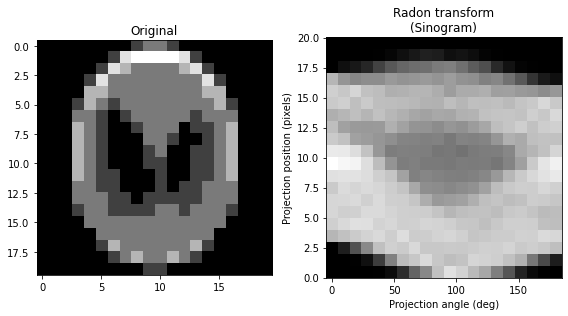

[[0 0 0 0 0 0 0 0 1 2 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 4 5 5 5 5 4 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 4 3 2 2 2 2 3 4 1 0 0 0 0 0]
 [0 0 0 0 1 4 2 2 2 2 2 2 2 2 4 1 0 0 0 0]
 [0 0 0 0 3 3 2 2 2 2 2 2 2 2 3 3 0 0 0 0]
 [0 0 0 1 3 2 1 2 2 2 2 2 2 2 2 3 1 0 0 0]
 [0 0 0 2 2 1 0 1 2 2 2 2 2 1 2 2 2 0 0 0]
 [0 0 0 3 2 1 0 0 1 2 2 2 0 1 1 2 3 0 0 0]
 [0 0 0 3 2 1 0 0 0 2 2 1 0 0 1 2 3 0 0 0]
 [0 0 0 3 2 1 0 0 0 1 2 0 0 1 1 2 3 0 0 0]
 [0 0 0 3 2 1 0 0 0 1 1 0 0 1 1 2 3 0 0 0]
 [0 0 0 3 2 1 1 0 0 0 1 0 0 1 1 2 3 0 0 0]
 [0 0 0 2 2 1 1 0 0 0 1 0 1 1 2 2 2 0 0 0]
 [0 0 0 2 2 2 1 1 0 1 1 1 1 1 2 2 2 0 0 0]
 [0 0 0 1 2 2 1 1 1 1 2 2 1 2 2 2 1 0 0 0]
 [0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0]
 [0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0]
 [0 0 0 0 0 1 3 2 2 2 2 2 2 3 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 3 2 2 3 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]]


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

plt_sinogram = sinogram.reshape(image.shape, order='F')
print(plt_sinogram.shape)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / plt_sinogram.shape[0]

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")

ax2.imshow(plt_sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, plt_sinogram.shape[0] + dy),
           aspect='auto')
fig.tight_layout()
fig.patch.set_facecolor('white')
plt.show()

## Matrix Inversion as a QUBO problem
This notebook is an extension and update to the implementation of the paper "Floating-Point Calculations on a Quantum Annealer: Division and Matrix Inversion" by M. Rogers and R. Singleton, 2020 [1]. 

The paper describes an approach to floating-point calculations on a quantum annealer. Specifically, they introduce a binary representation of the floating point variables. This representation is discrete, as they demonstrate their technique for 4 bit and 8 bit accuracy. With this measure they explain and derive the inversion of a matrix as a Quadratic Unconstrained Binary Optimization problem (QUBO), which is suitable to run on a DWave quantum annealer. 

We plan to expand the discrete (limited floating-point accuracy) to an integer problem solvable on the new hybrid solvers from DWave. In addition to solving integer style problems, the new hybrid solvers allow the integration of mathematical constraints. In the context of tomographic reconstruction for example non-negativity constraints are frequently used.

### Formulating the problem for the quantum annealer

The main challenge in formulating problems for quantum annealers is the description as a quadratic binary problem. Previously Rogers and Singleton have described matrix inversion as a quadratic binary problem for floating-point precision [1].   

Scalar notation of a QUBO problem: 

\begin{equation} E_{qubo}(a_i, b_{i,j}; q_i) = \sum_{i} a_i q_i + \sum_{i < j} b_{i, j} q_i q_j 
\end{equation} 


- $q_i$: Unknown binary variable (0, 1) we want to optimize for 
- $a_i$: Qubit bias/weight (real number)
- $b_{i,j}$: Coupling strength between spins $i$ and $j$ (real number)




Matrix (NxN) inversion is defined as: 

\begin{equation} M \cdot x = y \rightarrow x=M^{-1} \cdot y 
\end{equation} 

Formulate matrix inversion as a quadratic minimization problem with its minimum being the matrix inverse:

\begin{equation} H(x) = (Mx-y)^2 = \sum_{ijk=1}^{N} M_{ki} M_{kj} x^i x^j - 2 \sum_{ij=1}^{N} y_j M_{ji} x^i + \| y \|^2 = x^T M^T M x - x^T M^T y - y^t M x + y^T y
\end{equation} 

In matrix inversion and solving a linear system we usually solve for a vector of numbers which are typically not binary. Previously the common practice to obtain a floating point or integer representation of each component of x was to expand in powers of 2 multiplied by the boolean-valued variables $q_r^i \in \{0,1\}$:

\begin{equation} \chi^i = \sum_{r=0}^{R-1} 2^{-r} q_{r}^{i}
\end{equation} 

\begin{equation} x^i = 2\chi^i -1
\end{equation}

From the equation above we can see that the precision of the number heavily depends on the size or R (the number of bits used to represent the number). In the paper by Rogers and Singleton they opt for an R or 4, representing numbers as multiplies of 0.25 in the range of -1 to 3, this leads to a total number of 16 discrete values. 

The new constrained quadratic models (CQM) [2] running on DWaves Hybrid Samplers [3] enable the use of integer values in the quadratic model and therefore drastically expand solution possibilities. Further the possibility of introducing constraints is given. The new constrained quadratic model can be written as:

\begin{equation} H[q] = \sum_{i=1}^{N} a_i x_i + \sum_{i=1}^{N} \sum_{i \neq j}^{N}   b_{ij} x_i x_j  + c
\end{equation} 

- $x_i$: Unknown integer/binary variable we want to optimize for 
- $a_i$: Linear weight (real number)
- $b_{i,j}$: Quadratic term between $i$ and $j$ (real number)
- $c$: Inequality/equality constraints


## Implementation of the tomographic problem for the quantum annealer

### Problem formulation with sympy
We track our solution variables $x_i$ with the vector components. 

In [7]:
M = Matrix(system.tolist())
x_list = []
for i in range(image.shape[0]*image.shape[1]):
    x_list.append(sympify(str('x'+str(i))))
X = Matrix(x_list)
Y = Matrix(sinogram.tolist())
M_C = system
Y_C = sinogram

Reformulate the objective function into components of x as seen above: 


$H(x) = ||Mx-y||^2$

In [8]:
A = M.multiply(X)-Y
result = str(A.T.multiply(A)[0, 0])

In [9]:
# Make it compatible with lists
non_zero_entries = []
for i in reversed(range(len(X))):
    tmp_res = result
    result = result.replace('x'+str(i), 'x['+str(i)+']')
    if result != tmp_res:
        non_zero_entries.append(i)

Paste the above printed reformulation into cqm.set_objective(*printed reformulation*)

In [10]:
#Constraints
lowerBound = 0
upperBound = 10
# Singular matrix case:
# upperBound = 6

#### Create the constrained quadratic model

In [11]:
# Create the quadratic model
cqm = ConstrainedQuadraticModel()
# Create a list of integer variables for each solution component
x = []
for i in range(len(X)):
    x.append(Integer('x'+str(i)))
# Reformulated objective function to minimize here
program = 'cqm.set_objective(' + result + ')'
exec(program)
# # Add constraints, here non-negativity and range constraint
for c in range(len(X)):
    if c in non_zero_entries:
        cqm.add_constraint(x[c] >= lowerBound, label='constraint_' + str(2*c))
        cqm.add_constraint(x[c] <= upperBound, label='constraint_' + str(2*c+1))
    else: 
        cqm.add_constraint(x[c] == 0, label='constraint_' + str(len(X)*2+(c+1)))
# # Substitute integers with self loops
cqm.substitute_self_loops()

{'x200': '28ae33c1-b5ab-47b3-9d58-a30d6bdde2b5',
 'x239': 'a9d3a6fd-19a1-4b7d-baca-f77773225a86',
 'x259': '4e252643-120c-41ac-bed3-86b8c8883a6d',
 'x279': '69b73d33-7628-42a8-9058-4de3b536ad99',
 'x299': 'a020741d-60a2-4351-8337-1ed4b8a165d3',
 'x391': 'ba357839-5c4f-4ea2-a7f2-aa204a0ee434',
 'x392': '00583df4-91cb-4a43-b11d-4041acdd8603',
 'x393': 'a9c72974-8d9f-4cc9-a937-b09b155fb7ce',
 'x394': '5ba667cc-20d1-486d-909e-c13b7366b50c',
 'x221': '8b5c4116-bdf2-4025-a76c-8180851ceaec',
 'x241': '93bdb87f-67d7-4aed-aabd-f726a9e660e2',
 'x261': 'd612f056-0b20-4876-ba8b-2831199298b6',
 'x281': 'b2af1ac1-4bb6-4962-8032-8bf1c34947f4',
 'x386': '1cc64ace-faa2-430d-bb69-558d80cdc606',
 'x387': 'e4a62815-ace0-4956-9efb-4a533a58b8dc',
 'x388': '0f29b9a1-a427-45f4-82b5-5db69d7cc226',
 'x389': '387338e0-67d7-4c0d-b8c8-4ef258355e47',
 'x298': '7f3b25fa-ba51-4b66-81ed-80c5c3f098f1',
 'x318': '4487405e-32d5-4965-9e60-0fd91b95b530',
 'x338': '3837f426-44e8-4d06-a64e-206a0d793b80',
 'x357': 'acbec3a1-4

#### Run the constrained quadratic model on the hybrid sampler

In [12]:
# Sample from the Hybrid Solver on our constrained quadratic model
sampleset = LeapHybridCQMSampler().sample_cqm(cqm, label="Tomo Inversion Problem")
# Filter feasible solutions
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible) 
# Print...
# print(sampleset)
print(feasible_sampleset.first) 

Sample(sample={'00583df4-91cb-4a43-b11d-4041acdd8603': 0.0, '01b0bf78-1b9f-4a3c-a126-c42011ac69af': 0.0, '0344d7f9-e134-4f34-a7cf-f459bbbe9361': 0.0, '036a4e0b-5c01-433a-9fe9-9dcba77fc35e': 0.0, '04ad83cb-cb76-43ea-a22a-02836da6b354': 5.0, '04dcf646-85b4-4c27-b0b7-f6c5b4d82ef8': 0.0, '05187291-a39d-486a-99dc-e8fb9adcb7c7': 1.0, '05450d37-7b50-4834-8a36-ce88e3e650b3': 0.0, '05c97a9e-96eb-4aab-b32e-0cdae816fa34': 1.0, '06413b3a-a25d-4c9c-aa86-0a548a6c69a5': 1.0, '06ae5d7b-fb2a-4e4b-834e-a1f64c7305b2': 0.0, '075b419e-60ab-43fa-85f9-20f26822175a': 0.0, '091bd67d-6006-4fa0-b7ad-1b14c76419d2': 2.0, '09ed0d68-c90c-44a5-9ae5-32d98e1c8b99': 2.0, '0a9e5766-a662-4bff-945b-16064d57fb11': 1.0, '0bda7b0d-8ff6-4d5c-9558-12bfa40b2479': 6.0, '0bf97ee6-9d84-4bf6-8b88-d7e4848f3d45': 1.0, '0d4c1c9c-3bf7-484a-8f77-ff530733c7f5': 2.0, '0edf5f4b-2765-4e12-8890-a47469d9157e': 2.0, '0f29b9a1-a427-45f4-82b5-5db69d7cc226': 0.0, '0fc1868a-48c0-4c2f-b316-433b1b0a6dbc': 0.0, '103f0a78-9dd5-455f-a22e-90b3df18c4fa': 

In [13]:
import json
with open('sampleset_radonmat20x20_10range.json', 'w') as json_file:
    json.dump(feasible_sampleset.to_serializable(), json_file)

In [14]:
new_fes = feasible_sampleset
quantum_reconstructions = np.zeros(( len(new_fes), system.shape[1],))
index = np.arange(0, system.shape[1])
for s, r in zip(new_fes.data(fields=['sample', 'energy'], sorted_by='energy'), range(len(new_fes))):
    for i in index:
        search = 'x' + str(i)
        quantum_reconstructions[r, i] = s.sample[search]


### Classical solution
Solution using the classical inverse approximation.

In [15]:
print("Classical solution: ", np.linalg.pinv(M_C).dot(Y_C))
print("Condition number: ", np.linalg.cond(M_C))

Classical solution:  [ 1.68402334e-15  2.51308477e-16  1.93561883e-14 -5.38550836e-15
 -5.87532671e-15 -1.01739894e-15  1.38178444e-14 -2.94974545e-15
  1.01164267e-15 -8.31401793e-16  2.00000000e+00 -8.37514473e-15
  3.71992580e-15  4.22539575e-15  2.54491943e-16 -1.54169104e-16
 -1.17199925e-15  3.84580049e-15 -1.64253147e-15 -9.47163417e-15
  6.79890543e-15  2.39153654e-15  4.49536759e-15 -5.83413500e-15
  7.26800641e-16 -8.10115079e-16  1.00000000e+00  4.00000000e+00
  5.00000000e+00  5.00000000e+00  5.00000000e+00  5.00000000e+00
  4.00000000e+00  1.00000000e+00 -4.61852778e-14 -9.09452964e-15
  3.37288325e-15 -1.61422804e-14  2.78059603e-15 -5.55164414e-15
  3.68230506e-15  3.66997917e-15  9.28684457e-15  3.87288334e-15
 -1.52655666e-14  1.00000000e+00  4.00000000e+00  3.00000000e+00
  2.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  3.00000000e+00  4.00000000e+00  1.00000000e+00  8.65973959e-15
  1.90958360e-14 -8.44498351e-15  2.00376024e-15 -2.95660241e-15
 -2.

Solution using filtered backprojection.

FBP rms reconstruction error: 0.317


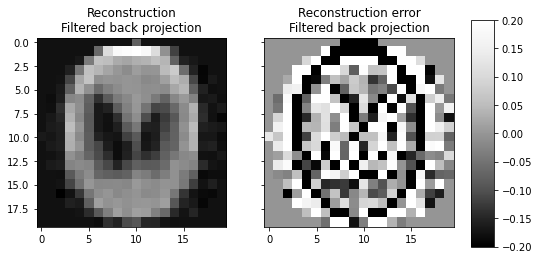

In [16]:
reconstruction_fbp = iradon(plt_sinogram, theta=np.linspace(0., 180., image.shape[0], endpoint=False), filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')
imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
shw0 = ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
shw1 = ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
fig.patch.set_facecolor('white')
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(shw1, cax=cbar_ax, fraction=0.0046)
plt.show()

Solution using quantum annealing.

QAR rms reconstruction error: 1.16


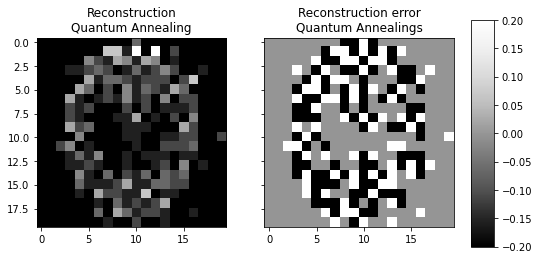

In [17]:
reconstruction = quantum_reconstructions[0].reshape(image.shape)
error = reconstruction - image
print(f'QAR rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')
imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nQuantum Annealing")
shw0 = ax1.imshow(reconstruction, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nQuantum Annealings")
shw1 = ax2.imshow(reconstruction - image, cmap=plt.cm.Greys_r, **imkwargs)
fig.patch.set_facecolor('white')
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(shw1, cax=cbar_ax, fraction=0.0046)
plt.show()

## References 
- [1] Rogers, Michael L., and Robert L. Singleton Jr. "Floating-point calculations on a quantum annealer: Division and matrix inversion." Frontiers in Physics 8 (2020): 265.
- [2] https://docs.ocean.dwavesys.com/en/latest/docs_dimod/reference/constrained.html
- [3] https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/samplers.html
- [4] https://docs.sympy.org/latest/index.html